#Let see if we can predict Exxon stock price with only oil price per barrel

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew

%matplotlib inline

#Step one: load the dataset
then see what our dataset looks like

In [ ]:
price_data = pd.read_excel('oil_exxon.xlsx')
price_data.head()

,date,exon_price,oil_price
0,2014-03-28,97.699997,106.64
1,2014-03-31,97.680000,105.95
2,2014-04-01,97.730003,105.70
3,2014-04-02,97.949997,103.37
4,2014-04-03,97.930000,104.88


we want to use the date column as our index instead of the index number given(0,1,2,3,...)

In [ ]:
#set the date as an index for the data
price_data.index = pd.to_datetime(price_data['date'])

#delete the original date column
del(price_data['date'])

price_data.head()

,exon_price,oil_price
date,,
2014-03-28,97.699997,106.64
2014-03-31,97.680000,105.95
2014-04-01,97.730003,105.70
2014-04-02,97.949997,103.37
2014-04-03,97.930000,104.88


#Step two: conduct EDA and clean the data

NEVER assume that out data is perfect as is!!!

start from checking datatype within the dataframe

In [ ]:
price_data.dtypes

,0
exon_price,float64
oil_price,float64


Fantastic! all of the datatypes are what they're suppose to be, but
noticed that the column's name spelled wrong? let's check again.

If so we want to fix that for the sake of integrity :D

In [ ]:
price_data.head()

,exon_price,oil_price
date,,
2014-03-28,97.699997,106.64
2014-03-31,97.680000,105.95
2014-04-01,97.730003,105.70
2014-04-02,97.949997,103.37
2014-04-03,97.930000,104.88


As we can see, it actually spelled wrong!

Let's fix them

In [ ]:
new_column_names = {
    'exon_price': 'exxon_price',
    'oil_price': 'oil_price_per_barrel'
}

price_data = price_data.rename(columns=new_column_names)
price_data.head()

,exxon_price,oil_price_per_barrel
date,,
2014-03-28,97.699997,106.64
2014-03-31,97.680000,105.95
2014-04-01,97.730003,105.70
2014-04-02,97.949997,103.37
2014-04-03,97.930000,104.88


Let's see if we have some missing values?

In [ ]:
price_data.isna().any()

,0
exxon_price,False
oil_price_per_barrel,True


Looks like we missing some oil price per barrel.

In this particular case droping the entire row might be the best solution because if we try to fill in the missing value, it's going to affect our final result

In [ ]:
price_data = price_data.dropna()
price_data.isna().any()

,0
exxon_price,False
oil_price_per_barrel,False


Great! we dealt with the missing values

let explore the data even further with a checklist
1. How is the data distribute?
2. Any obvious correlation?
3. Any outlier?
4. is the data skewed?

To see how the data distribute, let visualize it,

PS. In this case time is not relevant because we only using oil price to predict the stock price

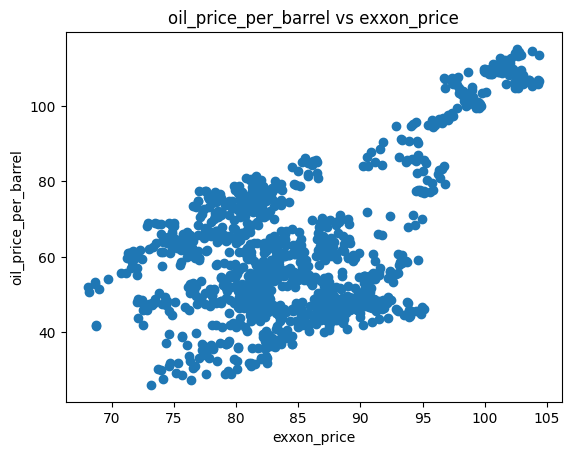

,exxon_price,oil_price_per_barrel
exxon_price,1.00000,0.60132
oil_price_per_barrel,0.60132,1.00000


In [ ]:
plt.scatter(price_data['exxon_price'], price_data['oil_price_per_barrel'])

plt.title('oil_price_per_barrel vs exxon_price')
plt.xlabel('exxon_price')
plt.ylabel('oil_price_per_barrel')

plt.show()
price_data.corr()

A quick look at the plot and the correlation values, we now know for certain that the exxon stock price and oil price have a moderate positive correlation (0.601)

Now let dive deeper into our data

In [ ]:
price_data.describe()

,exxon_price,oil_price_per_barrel
count,1248.000000,1248.000000
mean,84.802796,61.935000
std,7.424687,19.288424
min,68.120003,26.010000
25%,80.190002,48.162500
50%,83.024998,57.120000
75%,88.529999,70.725000
max,104.379997,115.190000


Next let's check for any outlier or if our data is skewed by plotting a histogram

array([[<Axes: title={'center': 'exxon_price'}>,
        <Axes: title={'center': 'oil_price_per_barrel'}>]], dtype=object)

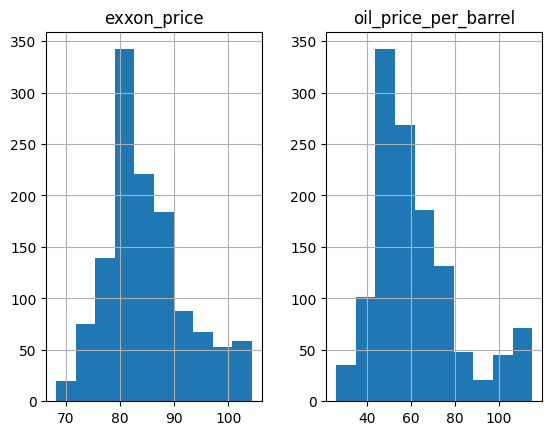

In [ ]:
price_data.hist()

our data looks a bit right-skewed, let verify it so we can confidently say that it's truly skewed

In [ ]:
exxon_kur = kurtosis(price_data['exxon_price'],fisher=True)
oil_kur = kurtosis(price_data['oil_price_per_barrel'],fisher=True)

exxon_skew = skew(price_data['exxon_price'])
oil_skew = skew(price_data['oil_price_per_barrel'])

display('Exxon Kurtosis: {:.2}'.format(exxon_kur))
display('Oil Kurtosis: {:.2}'.format(oil_kur))

display('Exxon Skew: {:.2}'.format(exxon_skew))
display('Oil Skew: {:.2}'.format(oil_skew))

'Exxon Kurtosis: 0.088'

'Oil Kurtosis: 0.53'

'Exxon Skew: 0.66'

'Oil Skew: 1.0'

Let's interpert these hectic number

**Kurtosis** with fisher method: How extreme are the outlier?

Kurtosis around 0 -> Normal distribution

Kurtosis > 0 -> More extreme values than usual

Kurtosis < 0 -> Fewer extreme values than usual

***The acceptable range is within +/- 1.0 but the ideal range is within +/- 0.5***
__________________________________________________________

**Skewness**: Is the data lopsided?

Skew around 0 -> normal distribution

Skew > 0 -> more number of high values

Skew < 0 -> less number of high values

***The acceptable range is within +/- 1.0 but the ideal range is within +/- 0.5***

_________________________________________________________

In out case both kurtosis are within the acceptable range. the skewness of exxon stock price is acceptable but for oil price, it's just about the acceptable threshold, so we can let it slide this time

#Step three: Build a model
starting by defining our input & output variables and split the data into train and testset

In [ ]:
#input -> don't forget that sklearn expect 2D array, so use [[...]]
X = price_data[['oil_price_per_barrel']]

#output -> what we are trying to predict
Y = price_data[['exxon_price']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

We can now go ahead and build a linear model

In [ ]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

After we got our model, we then examine the output

In [ ]:
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print(f'The coefficient is {coefficient:.4f}')
print(f'The intercept is {intercept:.4f}')

The coefficient is 0.2295
The intercept is 70.5460


#Step four: Evaluate the model

let evaluate the result, if the model is reliable

first, let's see some predictions in action

In [ ]:
y_pred = regression_model.predict(X_test)

y_pred[:5]

array([[82.39718427],
       [83.0168246 ],
       [81.66738567],
       [79.18882438],
       [84.12070236]])

Now let's recreate the model with statemodels to get more detailed statistics that sklearn didn't provide

In [ ]:
X2 = sm.add_constant(X)
model = sm.OLS(Y, X2)
est = model.fit()

let's get the Confidence Interval (95% by default) to find the range that the true coefficient of exxon stock price and oil price can possibly be in.

like we're saying: "We’re 95% confident the true relationship between oil price and stock price is somewhere between these two values"

In [ ]:
est.conf_int()

,0,1
const,69.358126,71.57579
oil_price_per_barrel,0.214372,0.24856


So we can see that the true coefficient of this relationship might be in range of 0.214 - 0.248 with 95% confidence

PS. because we can't possibly get all the possible value for both oil_price and Exxon stock price to calculate the true coefficient of the relationship, that's why we can't say that we are 100% confidence with our calculated coefficient

Hypothesis testing

- Null hypothesis: There is no relationship between Exxon stock price and oil price -> the coefficient is equal to 0

- Alternative hypothesis: There is a relation ship between xxon stock price and oil price -> the coefficient is not equal to 0

By these hypothesises, we have our goal in mind is to reject the null hypothesis because we think the relationship between these two things is existed.
And we can do that with caompare p-value against 0.05(alpha). If our p-value < alpha then we can reject the null hypothesis and accept the alternative hypothesis.

In [ ]:
est.pvalues

,0
const,0.000000e+00
oil_price_per_barrel,1.423529e-123


so we get really really small p-value here (1.423529 × 10⁻¹²³) it's 1.423529 followed by 122 zeros before it reaches any digits. or we can say it's pretty much 0 which by the way, less than alpha value so we can say that the relationship between oil price and exxon stock price is definitely existed!

So now we know for certain that the relationship exist, we can check how well our data fit the model by comparing the predict result from our model with the actual price to know how far off our predictions are

we can measure this by using these 3 metrices

1. **Mean absolute error** -> how far off is our prediction in the same unit as our data (in this case is USD) and doesn't care if the error is big or small
2. **Mean squared error** -> we square the error then average them to make our error seem bigger which is a way to punish our model for making larger error so it can improve overtime
3. **Root mean squared error** -> we square the error and average them like MSE but we then square root them back to the same unit as our data which is still punishing the model but milder than MSE

In [ ]:
model_mae = mean_absolute_error(y_test, y_pred)
model_mse = mean_squared_error(y_test, y_pred)
model_rmse = math.sqrt(model_mse)

print(f'Mean absolute error: {model_mae:.2f}')
print(f'Mean squared error: {model_mse:.2f}')
print(f'Root mean squared error: {model_rmse:.2f}')

Mean absolute error: 5.05
Mean squared error: 38.75
Root mean squared error: 6.23


Let's be conservative and use RMSE value which mean our predicted price is $6.23 off from the actual price

Let use one more thing to further examine our model

**R²**: to see how much of the movement in stock price can be explained with the oil price
R² = 1 -> perfect prediction
R² = 0 -> model is useless

PS. In financial modeling, a low R-squared value (below 0.5) doesn't always indicate that the model is poor or ineffective. Although a higher R-squared (typically above 0.7) is often desirable as it reflects a stronger correlation and better predictive accuracy, models with lower R-squared values can still provide valuable insights depending on the context.

In [ ]:
model_r2 = r2_score(y_test, y_pred)

print(f'R-squared: {model_r2:.2f}')

R-squared: 0.36


Our R² = 0.36 meaning that 36% of the movement in Exxon stock price can be explain by oil price, which is in my opinion is pretty alright in case of stock price.

If we want our R² to be higher we might consider adding more features (more column) into our dataframe so the model can have more context to work with.But  sometime adding more features might even hurt the model with too much complexity or some features added didn't benefit the prediction of the model.

So another thing we'd like to use alongside R² is adjusted R² which penalizes us for adding irrelevant features. If adding a variable actually improves the model, Adjusted R² will go up. If the new variable is just noise, Adjusted R² will go down.

But in this case we only have 1 feature so finding adjusted R² is irrelevant. But we're going to find it anyway :D

In [ ]:
adj_r2 = est.rsquared_adj
print(f'Adjusted R-squared: {adj_r2:.2f}')

Adjusted R-squared: 0.36


let create a summary for our output

In [ ]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:            exxon_price   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     705.7
Date:                Sat, 31 May 2025   Prob (F-statistic):          1.42e-123
Time:                        17:17:16   Log-Likelihood:                -3992.3
No. Observations:                1248   AIC:                             7989.
Df Residuals:                    1246   BIC:                             7999.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   70.4670 

Let's see the frequency of each error in prediction by plotting our residuals

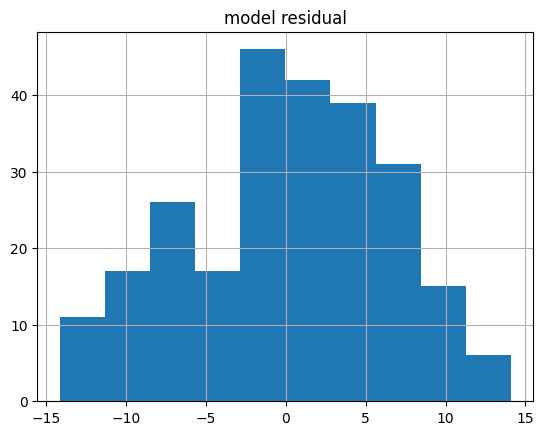

In [ ]:
(y_test - y_pred).hist()
plt.title('model residual')
plt.show()

Seem fine besides the range around -5 which is lower than expected because the residual distribution is expected to have a shape of a bell curve.

#Finally let compare our prediction with the actual price

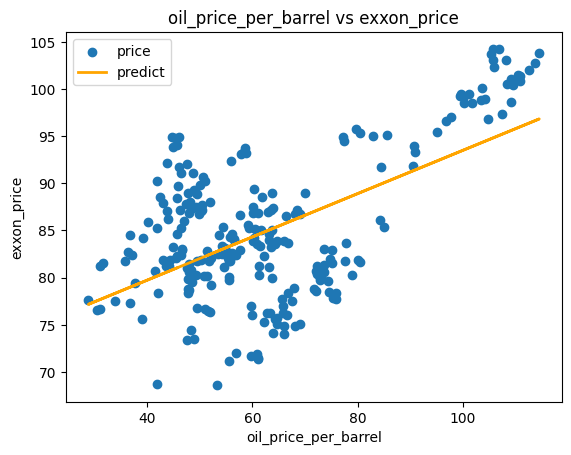

In [ ]:
plt.scatter(X_test,y_test, label = 'price')
plt.plot(X_test, y_pred, color = 'orange', linewidth = 2, label = 'predict')
plt.title('oil_price_per_barrel vs exxon_price')
plt.xlabel('oil_price_per_barrel')
plt.ylabel('exxon_price')
plt.legend()
plt.show()

Now let's pickle our model for later use

In [ ]:
import pickle

with open('exxon_vs_oil_price.sav', 'wb') as f:
    pickle.dump(regression_model, f)

with open('exxon_vs_oil_price.sav', 'rb') as f:
    regression_model2 = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[88.90570262]])

#And now we're done!